# A Case Study of TOI-3726
## Introduction
- [ExoMast Link](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html?searchQuery=%7B%22service%22%3A%22CAOMDB%22%2C%22inputText%22%3A%22TIC%20122695048%22%2C%22paramsService%22%3A%22Mast.Caom.Cone%22%2C%22title%22%3A%22MAST%3A%20TIC%20122695048%22%2C%22columns%22%3A%22*%22%2C%22caomVersion%22%3Anull%7D)
    - Filter on TESS
    - Compare with the 4th record.
    - See also `../data/toi_3726/TOI_3726_EXO_MAST_report.zip` for ExoMast TESS data report for the star.
- Flux of three TESS sectors was studied. The 1st and 3rd were both from sector 59 and the 2nd was from sector 73.
- The 2nd flux was excluded from the final curve.
- The 1st and 3rd are essentially the same data and was used to construct the final light curve.
- When the 3rd lc was flattened, a `polyorder=1` was used to remove the linear trend in the raw data.
## Concerns
- It is not obvious which star is TOI-3726. There is a cluster of several stars closely located with one another.
- Stellar Distance Table: TIC TESS Distance (taken from the ExoMast report). The two closest stars from the target are ~8 arcsec away. Is this something our telescope can resolve?
| Index | ID            | Mag   | Arcsec |
|-------|---------------|-------|--------|
| 1     | 0000000122695048 | 13.08 | 0.00   |
| 2     | 0000000122695043 | 15.75 | 8.07   |
| 3     | 0000000122695040 | 17.15 | 8.21   |

- This might be a reason why there are no ground follow-up observations for TOI-3726 at this point. Constructing aperture in AstroImageJ can be tricky.

In [1]:
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lightkurve import search_targetpixelfile

%matplotlib inline

/Users/sophia268238/GitHub/astronomy_ml/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [176]:
TOI="TOI-3726"
TIC="TIC 122695048"
EPOCH_TIME=3290.4324
tpf = search_targetpixelfile(TIC).download_all()

In [177]:
[t.meta['SECTOR'] for t in tpf]

[59, 73, 59]

In [178]:
tpf[2].interact(notebook_url='localhost:8889')

ERROR:bokeh.server.views.ws:Refusing websocket connection from Origin 'http://localhost:8888';                       use --allow-websocket-origin=localhost:8888 or set BOKEH_ALLOW_WS_ORIGIN=localhost:8888 to permit this; currently we allow origins {'localhost:8889'}


Text(0.5, 1.0, 'Fig 1.1 Sample Frame of Target ID: 122695048, Cadence: 1482118')

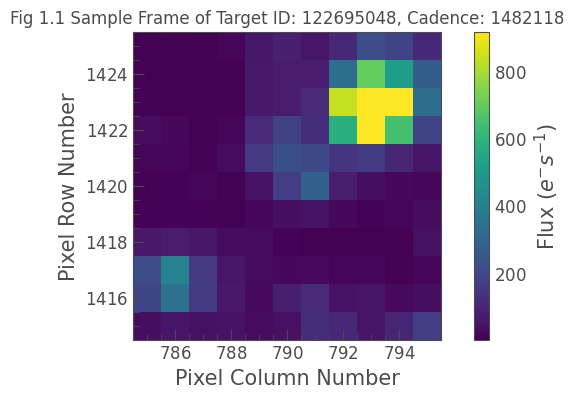

In [179]:
t0 = tpf[0]
t1 = tpf[1]
t2 = tpf[2]
t1.plot(frame=110)
plt.title("Fig 1.1 Sample Frame of Target ID: 122695048, Cadence: 1482118")

## Aperature Note
- Suprisingly, the aperture is not on the brighter region of the cut-out!
- Does it mean TOI-3726 is the dimmer of the 2 neighboring stars?

In [180]:
custom_mask = np.array(t0.pipeline_mask)
# custom_mask[:, :] = False
# custom_mask[8:9, 7:8] = True
# custom_mask

Text(0.5, 1.0, 'Fig 1.2 Sample Aperture of Target ID: 122695048, Cadence: 1211623')

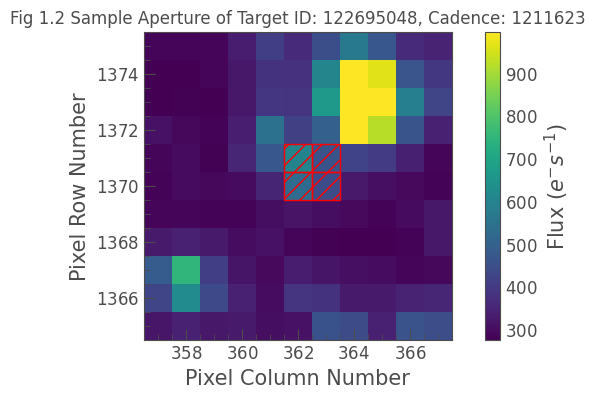

In [181]:
# Show the pipeline_mask
# t0.plot(aperture_mask=t0.pipeline_mask)
t0.plot(aperture_mask=custom_mask)
plt.title("Fig 1.2 Sample Aperture of Target ID: 122695048, Cadence: 1211623")

In [140]:
# lc0 = t0.to_lightcurve(aperture_mask='pipeline');
# lc1 = t1.to_lightcurve(aperture_mask='pipeline');
# lc2 = t2.to_lightcurve(aperture_mask='pipeline');
lc0 = t0.to_lightcurve(aperture_mask=custom_mask);
lc1 = t1.to_lightcurve(aperture_mask=custom_mask);
lc2 = t2.to_lightcurve(aperture_mask=custom_mask);

In [182]:
for i, lc_n in enumerate([lc0, lc1, lc2]):
    meta = lc_n.meta
    print(f"{i}: Sector: {meta.get('SECTOR')}, Camera: {meta.get('CAMERA')}, CCD: {meta.get('CCD')}, RA: {meta.get('RA')}, DEC: {meta.get('DEC')}")

0: Sector: 59, Camera: 1, CCD: 4, RA: 77.298354308809, DEC: 38.2285939240944
1: Sector: 73, Camera: 1, CCD: 3, RA: 77.298354308809, DEC: 38.2285939240944
2: Sector: 59, Camera: 1, CCD: 4, RA: 77.298354308809, DEC: 38.2285939240944


## Plot the Raw Flux
- Plotting the 3rd lc in scatted plot makes the transits stand out more.

Text(0.5, 1.0, 'Fig 2.3 Raw Light Curve of Sector 59_1')

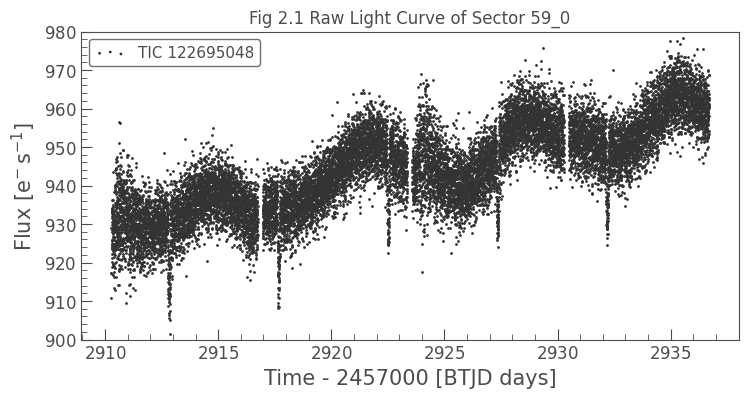

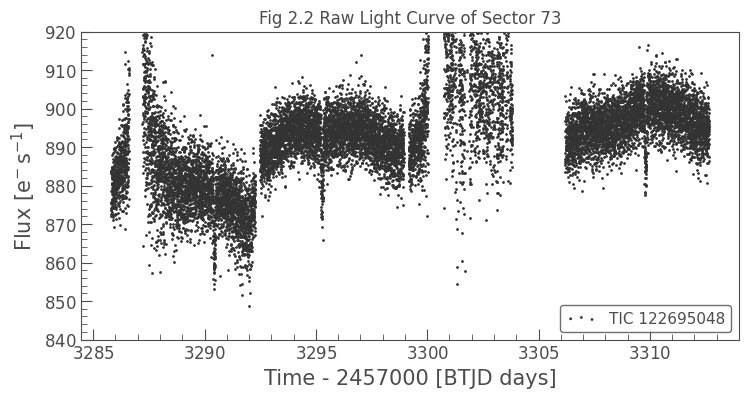

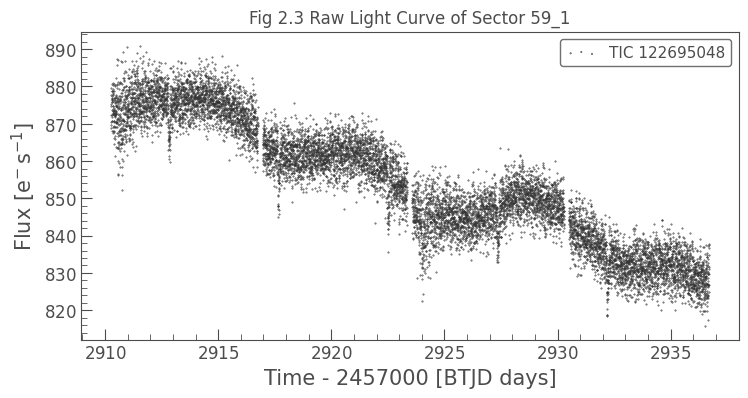

In [183]:
lc0.scatter()
plt.ylim(900,980)
plt.title("Fig 2.1 Raw Light Curve of Sector 59_0")
lc1.scatter()
plt.ylim(840,920)
plt.title("Fig 2.2 Raw Light Curve of Sector 73")
lc2.scatter(s=0.6)
plt.title("Fig 2.3 Raw Light Curve of Sector 59_1")

## Picking the Light Curve
- There are 3 light curves from sector 59, 73, and 59 again.
- The 1st and 2nd lc from sector 59 are identical except the 1st is a bit longer in the beginning.
- The lc from sector 73 has significant noise. Even after the significant noise was excluded, the overall noise level was still noticibly higher than the lc from 59. It was then excluded from the final fitting.
- In the end, the 2nd lc from sector 59 was used to derive the folded lc.

### lc0 Preprocessing

Text(0.5, 1.0, 'Fig 3.1 Cleaned, Normalized, and Flattened Light Curve for Sector 59_0')

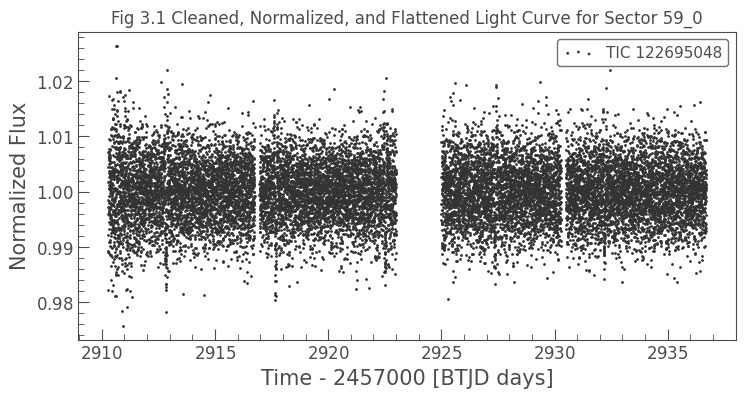

In [184]:
mask0 = ((lc0.time.value > 2900) & (lc0.time.value < 2923)) | (lc0.time.value >= 2925)
lc0_clean = lc0[mask0]
lc0_clean = lc0_clean.remove_outliers(sigma=5)
lc0_clean = lc0_clean.normalize()
lc0_clean = lc0_clean.flatten(polyorder=1)
lc0_clean.scatter()
plt.title("Fig 3.1 Cleaned, Normalized, and Flattened Light Curve for Sector 59_0")

### lc1 Preprocessing

Text(0.5, 1.0, 'Fig 3.2 Cleaned, Normalized, and Flattened Light Curve for Sector 73')

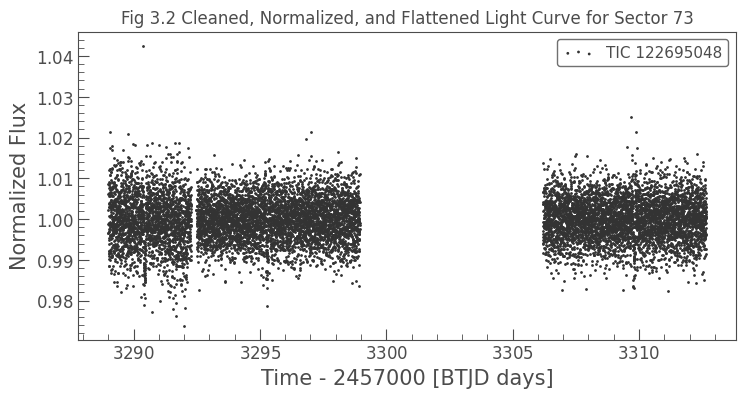

In [185]:
mask1 = ((lc1.time.value >= 3289) & (lc1.time.value <= 3299)) | (lc1.time.value >=3304)
lc1_clean = lc1[mask1]
lc1_clean = lc1_clean.remove_outliers(sigma=5)
lc1_clean = lc1_clean.flatten(polyorder=1)
lc1_clean = lc1_clean.normalize()
lc1_clean.scatter()
plt.title("Fig 3.2 Cleaned, Normalized, and Flattened Light Curve for Sector 73")

# lc_combined_clean = lc1_clean
# lc_combined_clean = lc_combined_clean
# lc_combined_clean.plot()
# plt.title("Fig 3.3 Combined Processed Light Curve for Sector 73")

### lc2 Preprocessing
- When flattening lc2, the default `polyorder=2` was changed to `1`. This is to remove the linear trend form the lightcurve.
- If `polyorder=2`, the transites would be optimized away to a great extent.

Text(0.5, 1.0, 'Fig 3.3 Combined Processed Light Curve for Sector 59_1')

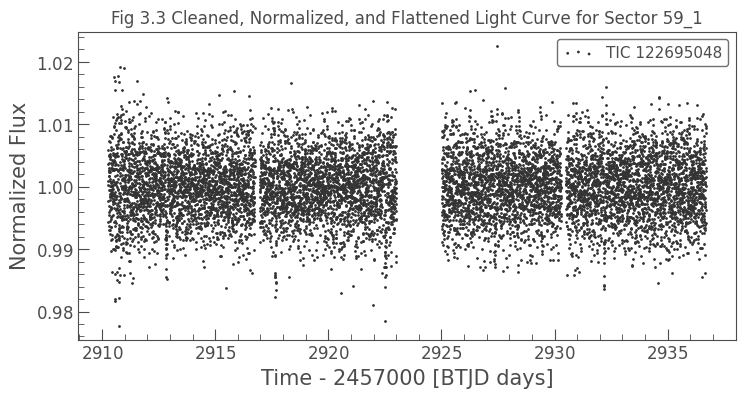

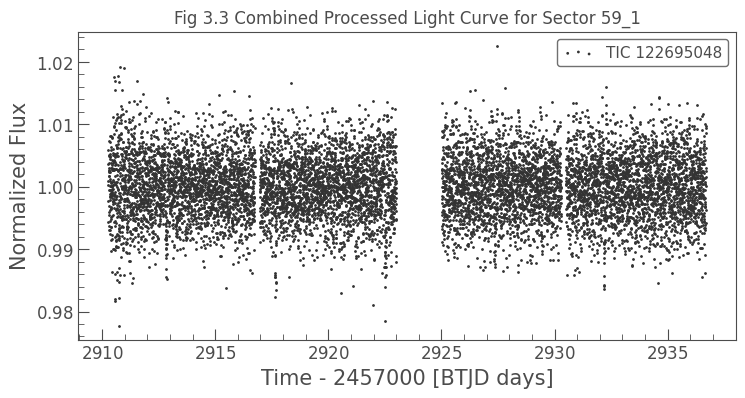

In [186]:
mask2 = ((lc2.time.value > 2900) & (lc2.time.value < 2923)) | (lc2.time.value >= 2925)
lc2_clean = lc2[mask2]
# lc2_clean = lc2_clean.remove_outliers(sigma=5)
lc2_clean = lc2_clean.flatten(polyorder=1)
lc2_clean = lc2_clean.normalize()
lc2_clean.scatter()
plt.title("Fig 3.3 Cleaned, Normalized, and Flattened Light Curve for Sector 59_1")

lc_combined_clean = lc2_clean
lc_combined_clean = lc_combined_clean
lc_combined_clean.scatter()
plt.title("Fig 3.3 Combined Processed Light Curve for Sector 59_1")

## Compare Sector 59 and 73 Folded Light Curves of TOI-3726
- It appears the T14

(-0.2, 0.2)

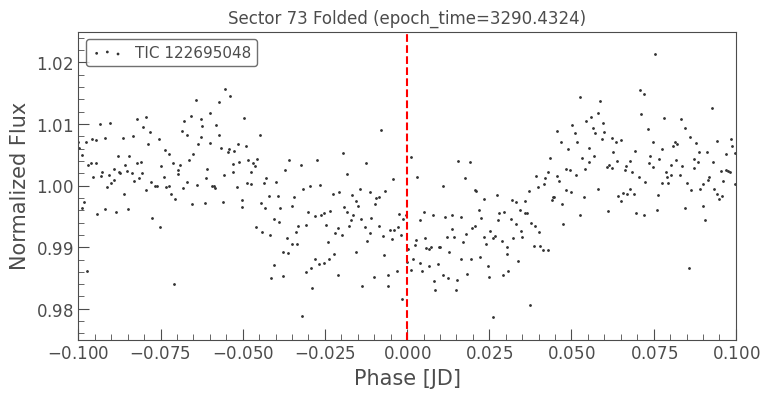

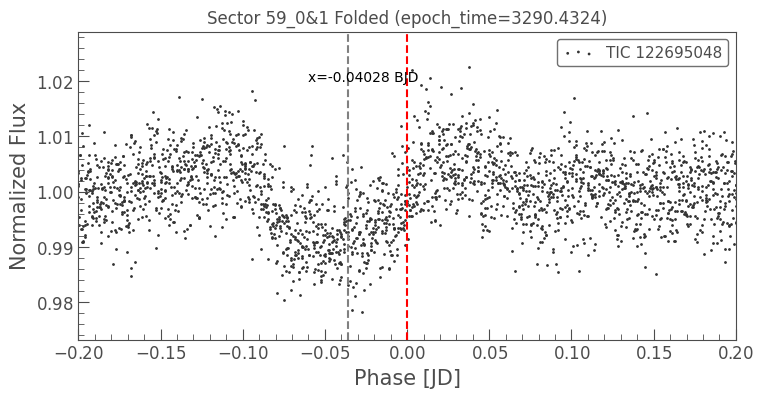

In [207]:
TRANSIT_PERIOD = 4.8404430882223

lc1_clean.fold(period=TRANSIT_PERIOD, epoch_time=EPOCH_TIME).scatter()
plt.xlim(-0.10, 0.10)
plt.ylim(0.975, 1.025)
plt.title(f"Sector 73 Folded (epoch_time={EPOCH_TIME})")
plt.axvline(x=0, color='red', linestyle='--', label="x = 0.0")

lc0_clean.append(lc2_clean).fold(period=TRANSIT_PERIOD, epoch_time=EPOCH_TIME).scatter()
plt.axvline(x=0, color='red', linestyle='--', label="x = 0.0")
plt.axvline(x=-0.0357, color='grey', linestyle='--', label="x = -0.04028")
plt.text(-0.06, 1.02, "x=-0.04028 BJD")
plt.title("Sector 59_0&1 Folded (epoch_time=3290.4324)")
plt.xlim(-0.2, 0.2)


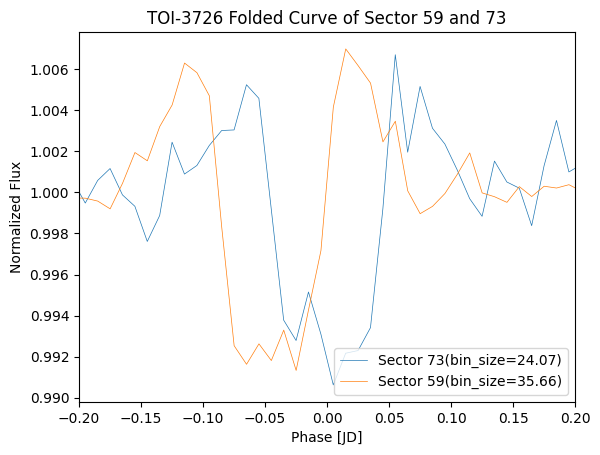

In [208]:
ax=plt.subplot()
binned_lc = lc1_clean.fold(period=TRANSIT_PERIOD, epoch_time=EPOCH_TIME).bin(time_bin_size=0.01)
binned_lc.plot(ax=ax)
plt.xlim(-0.2, 0.2)
plt.title(f"{TOI} Folded Curve of Sector 59 and 73")
binning_avg_size_73 = len(lc1_clean) / len(binned_lc)

binned_lc = lc0_clean.fold(period=TRANSIT_PERIOD, epoch_time=EPOCH_TIME).bin(time_bin_size=0.01)
binned_lc.plot(ax=ax)
binning_avg_size_59 = len(lc0_clean) / len(binned_lc)
plt.legend([f"Sector 73(bin_size={binning_avg_size_73:.2f})", f"Sector 59(bin_size={binning_avg_size_59:.2f})"])

In [189]:
(2460609.9016 - (3290.4324 + 2457000))/TRANSIT_PERIOD

65.99999094659226

Text(0.5, 1.0, 'Fig 4.1 Periodogram of the Combined Light Curve')

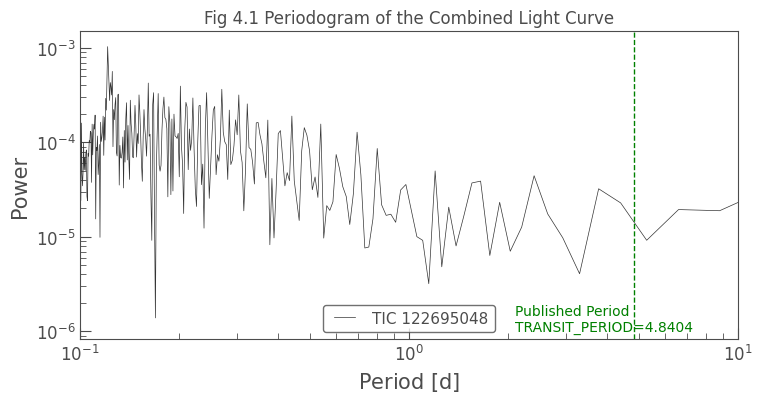

In [190]:
# Published transit period
TRANSIT_PERIOD = 4.8404430882223

pg = lc_combined_clean.to_periodogram(oversample_factor=1)
pg.plot(view='period', scale='log')
plt.xlim(0.1, 10)
plt.axvline(x=TRANSIT_PERIOD, color='g', linestyle='--', linewidth=1)
plt.text(x=2.1, y=15e-7, s='Published Period', fontsize=10, color='g')
plt.text(x=2.1, y=10e-7, s=f'TRANSIT_PERIOD={TRANSIT_PERIOD:.4f}', fontsize=10, color='g')
plt.title("Fig 4.1 Periodogram of the Combined Light Curve")

Text(0.5, 1.0, 'Fig 5.1 Folded Light Curve with Published Period (4.8404430882223 Days)')

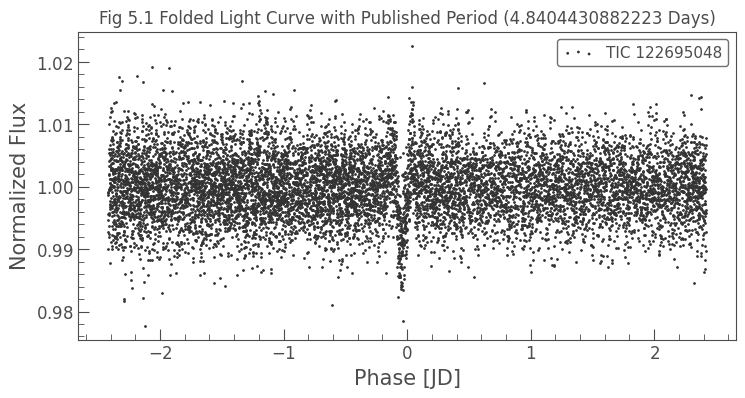

In [209]:
# Plot the folded curve.
folded_lc = lc_combined_clean.fold(period=TRANSIT_PERIOD, epoch_time=EPOCH_TIME)
folded_lc.scatter();
plt.title(f"Fig 5.1 Folded Light Curve with Published Period ({TRANSIT_PERIOD} Days)")

Text(0.5, 1.0, 'Fig 5.2 Zoomed in Folded Light Curve with Published Period (4.8404430882223 Days)')

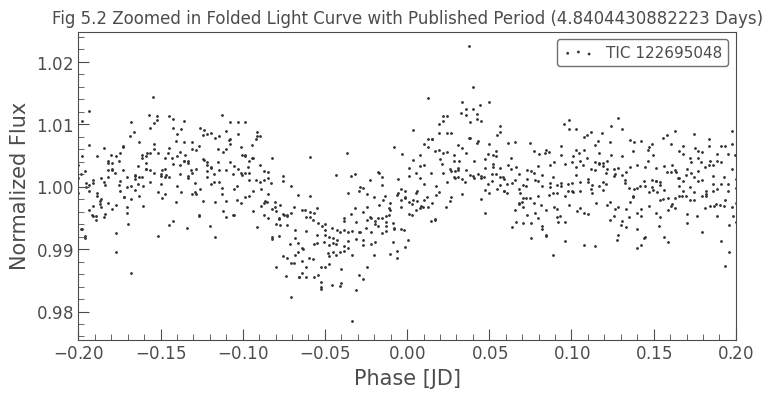

In [212]:
folded_lc.scatter();
plt.xlim(-0.2, 0.2)
plt.title(f"Fig 5.2 Zoomed in Folded Light Curve with Published Period ({TRANSIT_PERIOD} Days)")

Text(-2, 0.995, 'Average Binning Ratio: 21.3546')

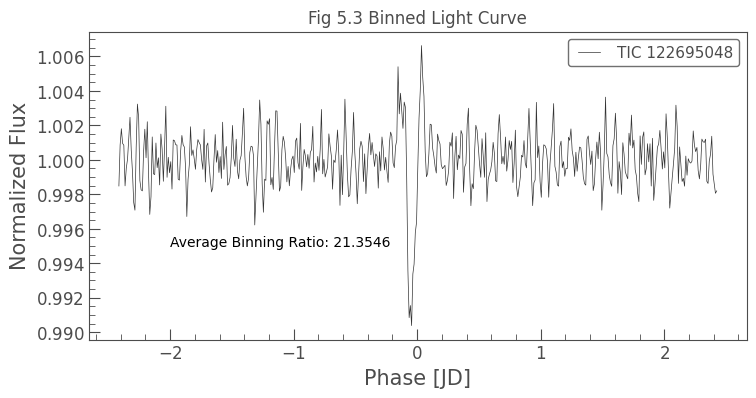

In [215]:
binned_lc = folded_lc.bin(time_bin_size=0.01)
binned_lc.plot()
plt.title("Fig 5.3 Binned Light Curve")
binning_avg_size = len(lc_combined_clean) / len(binned_lc)
plt.text(-2, 0.995, f"Average Binning Ratio: {binning_avg_size:.4f}")

Text(0.5, 1.0, 'Fig 5.4 Zoomed in Binned Light Curve')

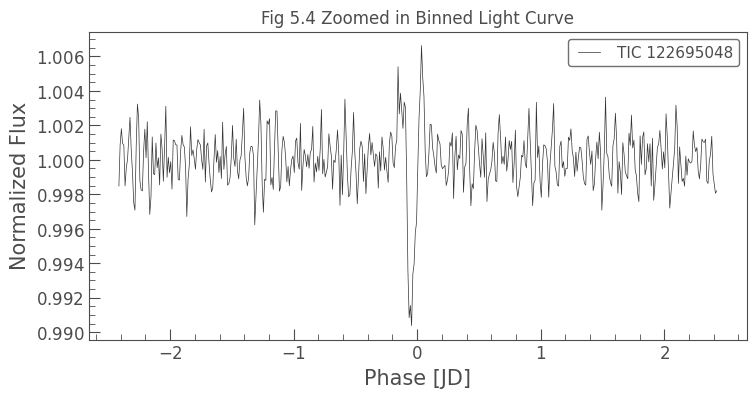

In [214]:
binned_lc = folded_lc.bin(time_bin_size=0.01)
binned_lc.plot()
# plt.xlim(-0.2, 0.2)
plt.title("Fig 5.4 Zoomed in Binned Light Curve")

# Disscussion
## Why the star appears to be brighter right before ingress and after egress of the transit?
### Possible Causes
- Comparing different data processing steps
    - The analysis above this cell has been based on extracting the photometric data directly from the TESS TPF file using the TESS pipeline aperture. This is similar to the SAP(Simple Aperture Photometry) flux.
    - To study this problem, TOI-3726 is analized again (**see the section below**) using the downloaded SAP and PDCSAP flux.
    - **The analysis indicates that the elevated ingress/egress rim is caused by the different processing steps.**
- Study of the ExoMast reports
    - There is a [sector 59 summary report](../data/toi_3726/tess2022330181042-s0059-s0059-0000000122695048-00688_dvm.pdf) once the `../data/toi_3726/TOI_3726_EXO_MAST_report.zip` is unzipped.
    - On page 5 of the report, it shows the `Phased Whitened Flux Time Series` graph. In this graph, we can see the same pattern of brighter ingress and egress rim of the curve.
    - The same pattern shows up for TOI-1858 in its [ExoMast full vetting report](https://exo.mast.stsci.edu/exomast_planet.html?planet=TOI1858.01#:~:text=Full-,Vetting,-Report)(select `Related Links` then `Full Vetting Report`).
    - **These 2 stars are unrelated, but the same pattern shows for both which seems to indicate this is an artificate of data processing.**
- Other possibilities (found using OpenAI)
    - ❌ Gravity darkening from the star
            - Probably not this, as the pattern would be asymmetric.
    - ❌ Starspots or faculae near the transit path
            - Probably not this either, as the pattern would be asymmetric.
    - ✅ Ellipsoidal variations
        - According to ExoFop, TOI-3726 is very similar to our Sun in both radius and Teff.
        - The period of 4.84 days must mean the exo-planet is much closer to the star than any planets of our Sun, so it might influence the shape of the star given enough mass.
    - ❓ Reflected light from the planet
      - The exo-planet needs to have thick and reflective atmosphere.
      - Not sure about this.

### Comparing the Binned Light Curve from Different Processing Paths

In [195]:
search_result = lk.search_lightcurvefile("TOI 3726", mission='TESS')
lc_file = search_result.download()
# Access the light curve
lc_pdcsap = lc_file.PDCSAP_FLUX
lc_sap = lc_file.SAP_FLUX


/var/folders/jp/5s_9hd2d4_5gkkj4yxpty2200000gp/T/ipykernel_45941/593169006.py:1: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  search_result = lk.search_lightcurvefile("TOI 3726", mission='TESS')
/Users/sophia268238/GitHub/astronomy_ml/.venv/lib/python3.9/site-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 6 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
/var/folders/jp/5s_9hd2d4_5gkkj4yxpty2200000gp/T/ipykernel_45941/593169006.py:4: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc_pdcsap = lc_file.PDCSAP_FLUX
/var/folders/jp/5s_9hd2d4_5gkkj4yxpty2200000gp/T/ipykernel_45941/593169006.py:5: LightkurveDeprecationWarning: The SAP_FLUX functi

Text(0.5, 1.0, 'SAP Flux')

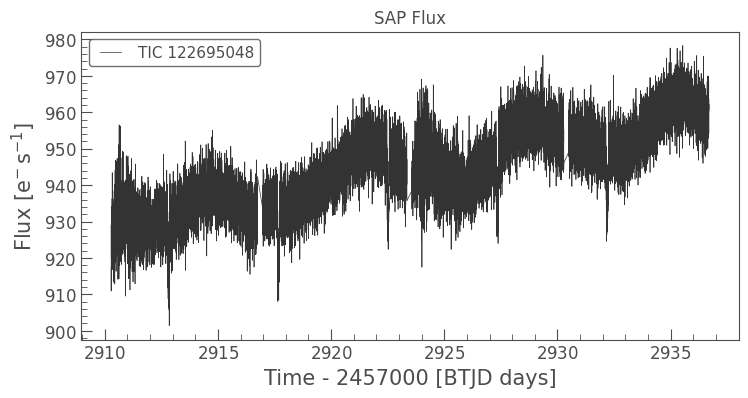

In [196]:
lc_sap.plot()
plt.title("SAP Flux")

Text(0.5, 1.0, 'PDCSAP Flux\n(where the linear trend has been removed and a bad section cut off near 2924)')

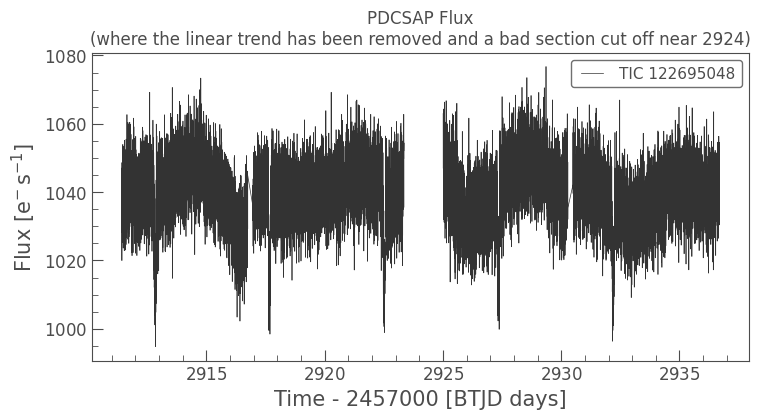

In [197]:
lc_pdcsap.plot()
plt.title("PDCSAP Flux\n(where the linear trend has been removed and a bad section cut off near 2924)")

In [198]:
# Use PDCSAP flux
lc = lc_pdcsap

#### Compare Three Binned Fluxes when Flattening the Curves at Different Steps

Text(0.5, 1.0, 'No Flattening')

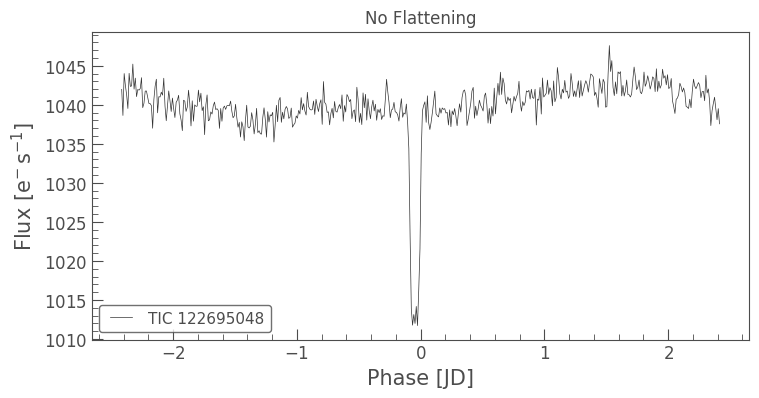

In [205]:
lc.fold(period=TRANSIT_PERIOD, epoch_time=3290.4324).bin(time_bin_size=0.01).plot()
plt.title("No Flattening")

Text(0.5, 1.0, 'Elevated Ingress/Egress Caused when Flattening before Folding')

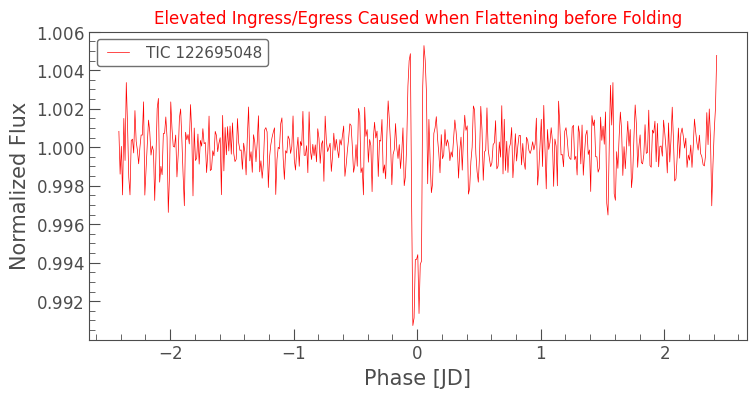

In [200]:
lc.flatten().fold(period=TRANSIT_PERIOD, epoch_phase=2916.22).bin(time_bin_size=0.01).plot(c='red')
plt.title("Elevated Ingress/Egress Caused when Flattening before Folding", c='red')

Text(0.5, 1.0, 'No Elevated Ingress/Egress when Flattening after Folding before Binning')

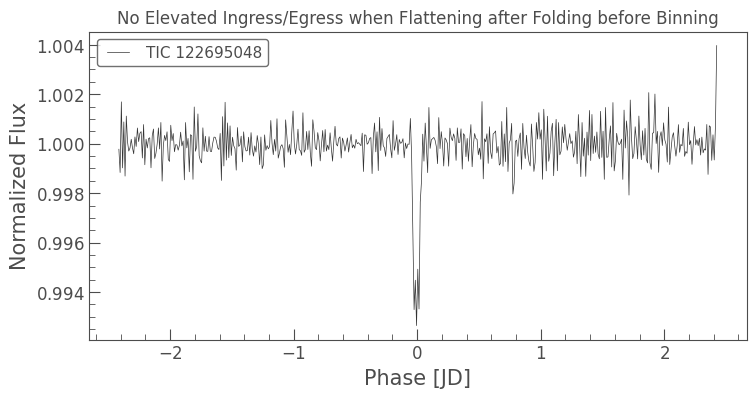

In [201]:
lc.fold(period=TRANSIT_PERIOD, epoch_phase=2916.22).flatten().bin(time_bin_size=0.01).plot()
plt.title("No Elevated Ingress/Egress when Flattening after Folding before Binning")

Text(0.5, 1.0, 'No Elevated Ingress/Egress when Flattening Data after Folding and Binning')

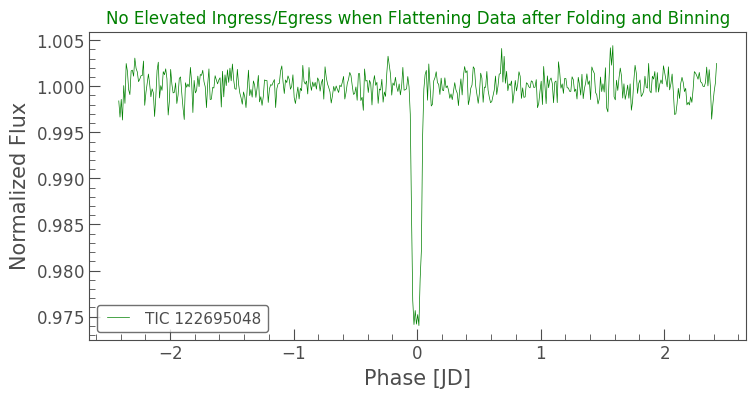

In [202]:
lc.fold(period=TRANSIT_PERIOD, epoch_phase=2916.22).bin(time_bin_size=0.01).flatten().plot(c='green')
plt.title("No Elevated Ingress/Egress when Flattening Data after Folding and Binning", c='green')